# **Random Forest**

In [1]:
import pandas as pd

dataset_work = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work.iloc[:,:-1]
y = dataset_work.iloc[:,-1].values
dataset_work.shape

(6435823, 19)

Dividiendo los datos en conjuntos de entrenamiento y prueba

In [4]:
from sklearn.model_selection import train_test_split

# Cargar el dataset
X = dataset_work.drop(columns=['MOROSIDAD']) 
y = dataset_work['MOROSIDAD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo de Random Forest

Para optimizar su rendimiento, se han seleccionado hiperparámetros mediante un proceso de ajuste previo. El modelo utiliza un conjunto de **100 árboles** en el bosque y selecciona características basándose en la raíz cuadrada del número total de características disponibles para cada división. Se ha limitado la **profundidad máxima** del bosque a 20 niveles para evitar el sobreajuste, junto con valores mínimos de muestras requeridas para dividir un nodo interno y para formar un nodo hoja. Adicionalmente, el modelo utiliza un esquema de muestreo **con reemplazo (bootstrap)**. A continuación, se presenta un resumen de los hiperparámetros seleccionados:

| **Hiperparámetro**     | **Valor Seleccionado** |
|------------------------|------------------------|
| `n_estimators`         | 100                    |
| `max_features`         | sqrt                   |
| `max_depth`            | 20                     |
| `min_samples_split`    | 5                      |
| `min_samples_leaf`     | 4                      |
| `bootstrap`            | True                   |

El proceso incluye las siguientes etapas principales: entrenamiento del modelo con los datos de entrenamiento, evaluación mediante validación cruzada para calcular el AUC-ROC promedio, predicción en un conjunto de prueba, y cálculo de métricas de desempeño como la matriz de confusión, el informe de clasificación, y el AUC-ROC. Finalmente, se mide el tiempo total de ejecución del proceso.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# Registro del tiempo de inicio
start_time = time.time()

# Configuración del modelo de Random Forest con los hiperparámetros proporcionados
model = RandomForestClassifier(
    n_estimators=100,          # Número de árboles en el bosque
    max_features='sqrt',       # Número máximo de características para considerar en cada división
    max_depth=20,              # Profundidad máxima de los árboles
    min_samples_split=5,       # Mínimo número de muestras requeridas para dividir un nodo
    min_samples_leaf=4,        # Mínimo número de muestras requeridas en un nodo hoja
    bootstrap=True,            # Utilizar muestreo con reemplazo
    random_state=42            # Semilla para reproducibilidad
)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación del modelo con validación cruzada (cv=3)
auc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')

# Promedio de AUC-ROC
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")  # Mostrar con 4 decimales

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluar el rendimiento del modelo
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el AUC-ROC en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC en conjunto de prueba: {roc_auc:.4f}")  # Mostrar con 4 decimales

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.4f} segundos.")  # Segundos con 4 decimales

## **Curva ROC (característica operativa del receptor)**

**Propósito:** Mostrar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación.

**Beneficio:** Permite evaluar visualmente la capacidad del modelo para distinguir entre las clases y calcular el AUC-ROC (área bajo la curva).

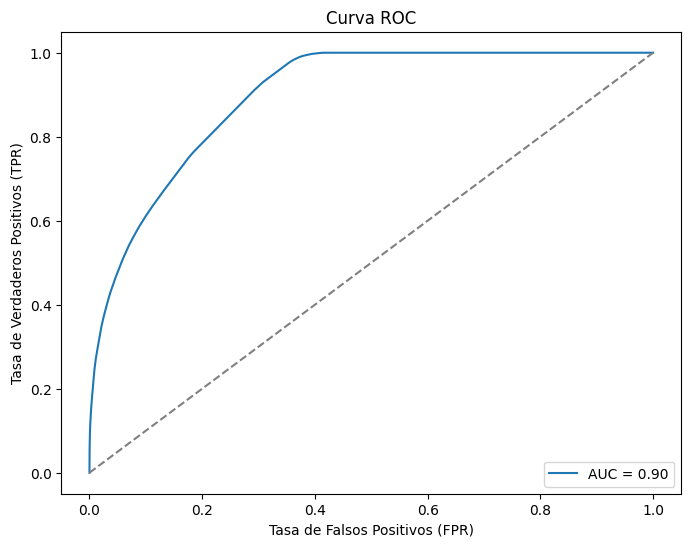

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


### Análisis del Gráfico: Curva ROC

Este gráfico muestra la **Curva ROC (Receiver Operating Characteristic)** para el modelo de árboles de decisión aplicado a la predicción de la morosidad tributaria. La curva traza la **tasa de verdaderos positivos (TPR)** contra la **tasa de falsos positivos (FPR)**, evaluando la capacidad del modelo para distinguir entre los contribuyentes morosos y no morosos.

- **Interpretación del AUC (Área Bajo la Curva):**  
  El valor del AUC es **0.90**, lo cual indica un excelente desempeño del modelo en la clasificación de los contribuyentes. Un AUC cercano a 1 implica que el modelo tiene alta capacidad para predecir correctamente si un contribuyente será moroso o no. Este resultado sugiere que el modelo es muy efectivo y confiable en este caso.

- **Desempeño del Modelo:**  
  La curva se encuentra alejada de la diagonal gris (que representa una clasificación aleatoria), lo que indica que el modelo tiene un desempeño significativamente mejor que el azar. En particular, esto significa que el modelo puede minimizar tanto los falsos positivos (clasificar erróneamente a un contribuyente no moroso como moroso) como los falsos negativos (clasificar erróneamente a un moroso como no moroso).

- **Relevancia en el Contexto Tributario:**  
  En el contexto de la predicción de morosidad tributaria, un AUC elevado es crítico, ya que ayuda a identificar correctamente a los morosos con alta probabilidad, permitiendo priorizar las intervenciones para reducir el riesgo financiero para la administración tributaria.

### Recomendaciones:
1. **Evaluar otras métricas:** Aunque el AUC es elevado, se debería complementar el análisis con métricas adicionales, como la matriz de confusión, precisión, sensibilidad y especificidad, para obtener una visión más completa.
2. **Optimización del umbral:** Ajustar el umbral de decisión para balancear entre verdaderos positivos y falsos positivos dependiendo de los costos asociados a cada tipo de error en el contexto tributario. 

Este gráfico evidencia que el modelo de árboles de decisión está funcionando adecuadamente para el problema planteado.

## **Gráfico de Precisión-Recall (Precision-Recall Curve)**
**Propósito:** Evaluar el desempeño del modelo en términos de precisión y sensibilidad (recall) para diferentes umbrales.

**Beneficio:** Es especialmente útil si las clases están desbalanceadas, ya que pone mayor énfasis en los verdaderos positivos.

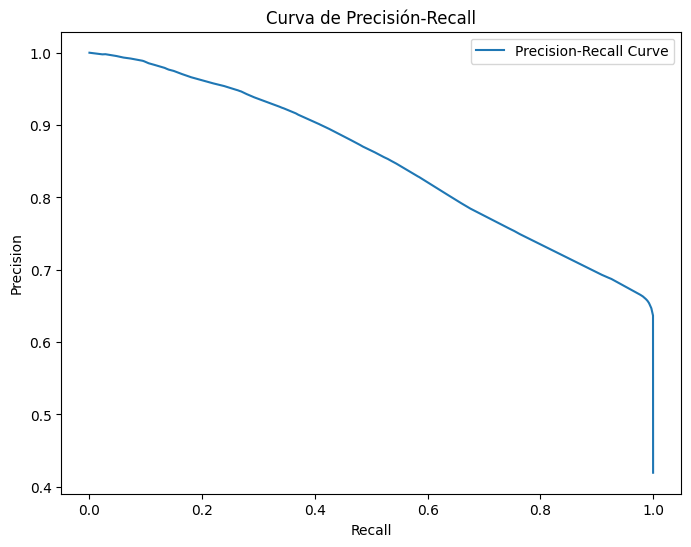

In [16]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall")
plt.legend(loc="upper right")
plt.show()


### Análisis del Gráfico: Curva de Precisión-Recall

Este gráfico muestra la relación entre la **precisión** (proporción de verdaderos positivos entre las predicciones positivas) y el **recall** (proporción de verdaderos positivos identificados correctamente) para el modelo de árboles de decisión en la predicción de la morosidad tributaria. 

#### Interpretación:
1. **Forma de la curva:**  
   La curva mantiene una precisión alta para valores bajos de recall, lo que indica que, al inicio, el modelo es muy selectivo y clasifica con alta precisión a un menor número de contribuyentes como morosos. Sin embargo, a medida que el recall aumenta (es decir, se intentan identificar más casos de morosidad), la precisión disminuye gradualmente. Esto es un comportamiento típico en problemas de clasificación, donde existe un compromiso entre precisión y recall.

2. **Desempeño general:**  
   La curva indica que el modelo mantiene una buena relación entre precisión y recall en la mayor parte del rango. Sin embargo, la precisión cae significativamente al acercarse a valores altos de recall (alrededor de 1), lo que sugiere que el modelo comienza a clasificar erróneamente a un mayor número de contribuyentes no morosos como morosos.

3. **Implicaciones en el contexto tributario:**  
   En el análisis de morosidad tributaria, es importante encontrar un equilibrio entre precisión y recall. Una precisión alta asegura que los contribuyentes clasificados como morosos realmente lo sean, mientras que un recall alto garantiza que el modelo detecte la mayor cantidad de morosos posible. En este caso, el modelo parece adecuado para identificar morosos con relativa fiabilidad, pero es posible que se necesiten ajustes si los errores de clasificación (falsos positivos o falsos negativos) tienen costos desiguales.

#### Recomendaciones:
1. **Seleccionar un punto de corte adecuado:**  
   Identificar el umbral que ofrezca el mejor equilibrio entre precisión y recall, considerando las prioridades del problema. Por ejemplo, si los falsos negativos (no identificar a un moroso) tienen un costo elevado, se puede priorizar un recall más alto, incluso a costa de una menor precisión.

2. **Evaluar el F1-Score:**  
   El F1-score combina precisión y recall en una sola métrica y puede ser útil para determinar el desempeño óptimo del modelo según las necesidades del análisis.

3. **Análisis de casos extremos:**  
   Investigar por qué la precisión cae drásticamente en valores altos de recall y evaluar si el modelo puede mejorarse mediante técnicas como la poda de árboles, ajuste de hiperparámetros o el uso de datos balanceados.

En general, el gráfico sugiere que el modelo de árboles de decisión tiene un desempeño sólido en la predicción de la morosidad tributaria, pero debe optimizarse para maximizar su utilidad en contextos específicos.

## **Matriz de Confusión con Mapa de Calor**

**Propósito:** Visualizar la matriz de confusión de forma más interpretativa usando un mapa de calor.

**Beneficio:** Facilitar la identificación de aciertos y errores del modelo en las clases predichas.

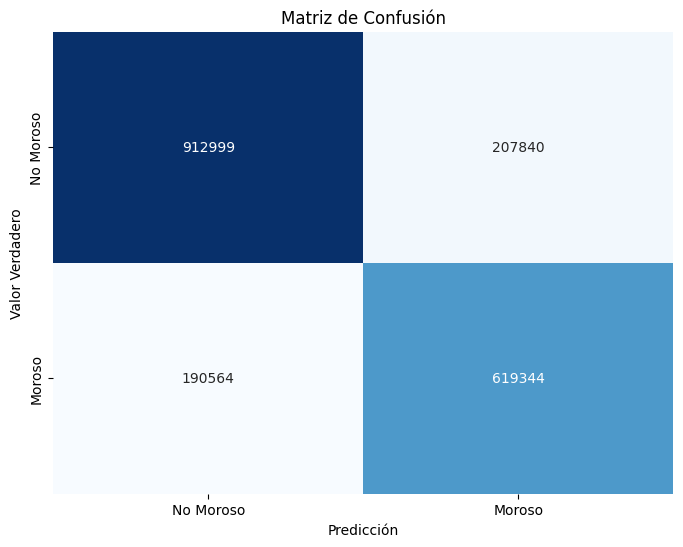

In [17]:
import seaborn as sns
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()


### Análisis del Gráfico: Matriz de Confusión

Este gráfico presenta la **matriz de confusión** para el modelo de árboles de decisión aplicado a la predicción de morosidad tributaria. Los valores en la matriz representan el rendimiento del modelo al clasificar correctamente o incorrectamente a los contribuyentes como **morosos** o **no morosos**. 

#### Interpretación:
1. **Verdaderos Positivos (Morosos Predichos Correctamente):**  
   El modelo identificó correctamente a **619,344 contribuyentes morosos**. Esto indica que el modelo tiene una buena capacidad para detectar casos de morosidad.

2. **Verdaderos Negativos (No Morosos Predichos Correctamente):**  
   Se clasificaron correctamente como no morosos a **912,999 contribuyentes**. Este número también es alto, lo que muestra que el modelo es confiable para evitar clasificar como morosos a quienes no lo son.

3. **Falsos Positivos (No Morosos Clasificados como Morosos):**  
   El modelo clasificó incorrectamente a **207,840 contribuyentes no morosos** como morosos. Este error puede generar esfuerzos innecesarios en la gestión de cobro, afectando la eficiencia del sistema tributario.

4. **Falsos Negativos (Morosos Clasificados como No Morosos):**  
   **190,564 contribuyentes morosos** fueron clasificados como no morosos. Estos errores son preocupantes, ya que representan pérdidas potenciales para la administración tributaria al no detectar contribuyentes con riesgo de morosidad.

#### Implicaciones en el Contexto Tributario:
- Los **falsos negativos** (morosos no detectados) representan una amenaza directa para los ingresos fiscales, ya que son contribuyentes que podrían incumplir pagos y no ser identificados a tiempo.
- Los **falsos positivos** (no morosos clasificados como morosos) pueden implicar costos operativos adicionales al priorizar contribuyentes que no son problemáticos.
  
#### Recomendaciones:
1. **Ajustar el umbral de clasificación:**  
   Modificar el umbral para reducir los falsos negativos si se prioriza la detección de morosos, aunque esto podría aumentar los falsos positivos.

2. **Evaluar técnicas de mejora:**  
   - Aplicar métodos de recolección de datos más equilibrados, como sobremuestreo de la clase morosa.
   - Implementar técnicas avanzadas como el ajuste de hiperparámetros o modelos combinados (ensembles) para mejorar el desempeño.

3. **Análisis costo-beneficio:**  
   Considerar los costos asociados a los falsos positivos y falsos negativos en el contexto del sistema tributario para determinar cuál error es más costoso y ajustar el modelo en consecuencia.

En general, el modelo tiene un desempeño razonablemente bueno, pero podría optimizarse para reducir los errores más críticos en el contexto tributario.

## **Importancia de las Características (Coeficientes)**

**Propósito:** Mostrar gráficamente la importancia de las variables en la predicción de la morosidad basada en los coeficientes del modelo de regresión logística.

**Beneficio:** Ayuda a interpretar el modelo ya identificar las variables más influyentes.

C:\Users\hrqui\AppData\Local\Temp\ipykernel_11996\552896770.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')


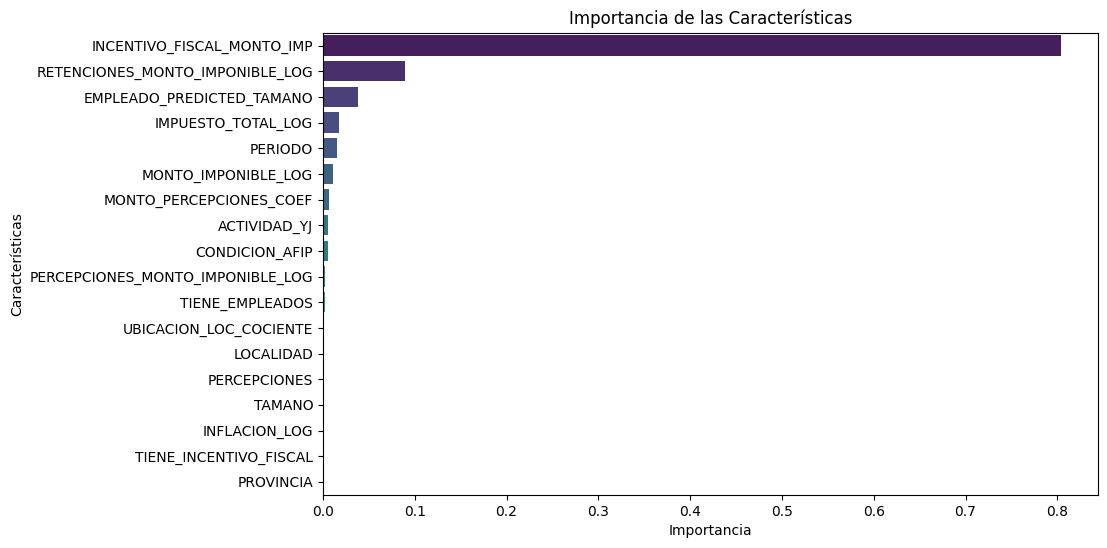

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la importancia de las características desde el modelo
importances = model.feature_importances_

# Crear un DataFrame con las características y su importancia
coef_df = pd.DataFrame({
    'Características': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



### Análisis del Gráfico: Importancia de las Características

Este gráfico representa la importancia relativa de las características utilizadas por el modelo de árboles de decisión para predecir la **morosidad tributaria**. Las barras indican cuánto contribuye cada característica al proceso de clasificación del modelo.

#### Interpretación:
1. **Características más importantes:**
   - **INCENTIVO_FISCAL_MONTO_IMP:**  
     Es, por mucho, la característica más relevante en el modelo, con una importancia cercana a 0.8. Esto sugiere que los incentivos fiscales otorgados a los contribuyentes (monto imputado) tienen un impacto determinante en predecir si un contribuyente será moroso. Esto puede deberse a que los incentivos fiscales pueden influir en la liquidez o el comportamiento de pago.
   - **RETENCIONES_MONTO_IMPONIBLE_LOG:**  
     La segunda característica más importante, con una importancia significativamente menor, está relacionada con las retenciones fiscales. Esto indica que el monto de las retenciones tiene una relación moderada con la probabilidad de morosidad.
   - **EMPLEADO_PREDICTED_TAMANO:**  
     El tamaño previsto del negocio basado en el número de empleados es también relevante, sugiriendo que contribuyentes de diferentes tamaños presentan comportamientos de pago distintos.

2. **Características moderadamente importantes:**
   - **IMPUESTO_TOTAL_LOG** y **PERIODO** tienen menor influencia, pero aún son relevantes. El monto total del impuesto puede reflejar la carga tributaria que enfrenta el contribuyente, mientras que el período podría capturar patrones temporales de morosidad.

3. **Características con menor importancia:**
   - Variables como **PROVINCIA**, **TIENE_INCENTIVO_FISCAL**, y **INFLACION_LOG** tienen importancias casi nulas en el modelo. Esto sugiere que, en este caso, no aportan información significativa para la predicción de morosidad.

#### Implicaciones en el Contexto Tributario:
- **INCENTIVO_FISCAL_MONTO_IMP** como principal predictor sugiere que los programas de incentivos fiscales podrían estar correlacionados con el riesgo de morosidad. Esto podría deberse a mal uso de los incentivos o problemas relacionados con la capacidad del contribuyente para cumplir sus obligaciones tras recibirlos.
- **RETENCIONES_MONTO_IMPONIBLE_LOG** y **IMPUESTO_TOTAL_LOG** indican que las políticas fiscales relacionadas con montos retenidos y las obligaciones totales impactan significativamente el comportamiento de pago. Esto podría reflejar que los contribuyentes con mayores cargas tributarias o con retenciones altas enfrentan mayor probabilidad de incumplimiento.

#### Recomendaciones:
1. **Analizar la relación entre incentivos fiscales y morosidad:**  
   Evaluar si existen patrones específicos que expliquen por qué los incentivos fiscales son tan determinantes. Esto podría ayudar a mejorar la política de asignación de incentivos y reducir el riesgo de morosidad.

2. **Revisar otras características:**  
   Aunque algunas variables tienen poca importancia en este modelo, podría ser útil explorarlas con otros enfoques (e.g., técnicas de selección de características o transformación de variables).

3. **Optimización del modelo:**  
   Considerar que las características menos relevantes podrían ser eliminadas para simplificar el modelo, reduciendo la complejidad sin afectar significativamente el desempeño.

Este análisis subraya que el modelo de árboles de decisión está dominado por unas pocas variables clave, lo cual puede ser beneficioso para diseñar estrategias focalizadas en la gestión de riesgos tributarios.

## **Distribución de las Probabilidades Predichas**

**Propósito:** Mostrar la distribución de las probabilidades predichas para cada clase.

**Beneficio:** Permite analizar cómo el modelo clasifica los datos y si existe algún solapamiento importante entre las clases.

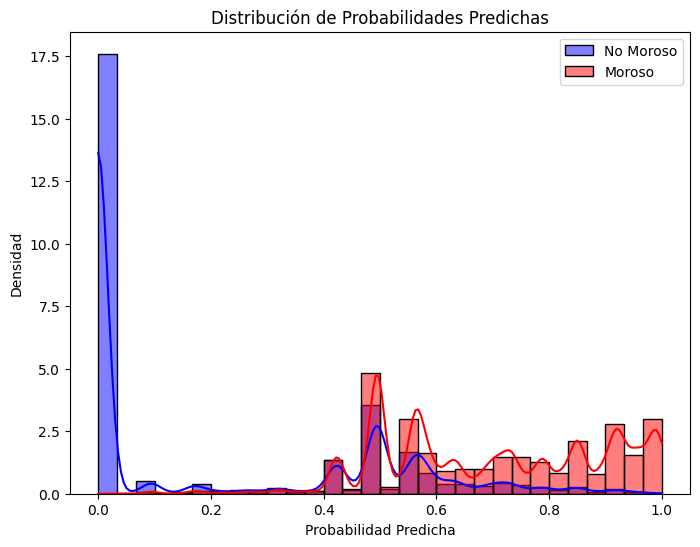

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], label='No Moroso', color='blue', kde=True, stat='density', bins=30)
sns.histplot(y_pred_proba[y_test == 1], label='Moroso', color='red', kde=True, stat='density', bins=30)
plt.title("Distribución de Probabilidades Predichas")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Densidad")
plt.legend()
plt.show()


### Análisis del Gráfico: Distribución de Probabilidades Predichas

Este gráfico muestra la **distribución de las probabilidades predichas** por el modelo de árboles de decisión para las clases de contribuyentes **morosos** (rojo) y **no morosos** (azul). Cada color representa la densidad de las probabilidades que el modelo asigna a cada clase.

#### Interpretación:
1. **Distribución para la clase "No Moroso":**  
   La mayoría de los contribuyentes clasificados como no morosos tienen probabilidades predichas cercanas a 0. Esto muestra que el modelo es bastante confiable en clasificar con alta seguridad a esta clase, ya que pocas instancias tienen probabilidades intermedias.

2. **Distribución para la clase "Moroso":**  
   Para los morosos, las probabilidades se distribuyen de forma más dispersa, con picos en valores intermedios (entre 0.4 y 0.6) y un grupo significativo en probabilidades altas (cercanas a 1). Esto indica que el modelo puede identificar correctamente a una parte importante de los morosos con alta confianza, aunque existe una cantidad notable de casos con probabilidades intermedias.

3. **Superposición de probabilidades:**  
   Hay una notable superposición en el rango de probabilidades intermedias (entre 0.3 y 0.6), lo que sugiere que en esta región el modelo tiene más dificultad para diferenciar entre morosos y no morosos. Esto puede generar confusión, incrementando los falsos positivos o falsos negativos.

#### Implicaciones en el Contexto Tributario:
- Los contribuyentes con probabilidades predichas cercanas a 1 (morosos) y a 0 (no morosos) pueden ser tratados con alta confianza, ya que el modelo está seguro de su clasificación.
- En el rango intermedio (probabilidades entre 0.3 y 0.6), se encuentran los casos más ambiguos. En este contexto, sería prudente aplicar estrategias adicionales (como análisis manual o cruzar con otras fuentes de datos) para validar si un contribuyente realmente es moroso o no.

#### Recomendaciones:
1. **Ajuste del Umbral de Clasificación:**  
   En lugar de utilizar el umbral estándar de 0.5, se podría ajustar para minimizar el impacto de los casos ambiguos dependiendo de las prioridades del sistema tributario. Por ejemplo:
   - Un umbral más bajo aumentará el **recall** (identificar más morosos), aunque con más falsos positivos.
   - Un umbral más alto priorizará la **precisión**, clasificando con mayor certeza a los morosos.

2. **Análisis Focalizado en la Región Intermedia:**  
   Los contribuyentes con probabilidades en el rango de 0.3 a 0.6 deberían ser tratados con precaución. Se podría diseñar un sistema de alerta temprana para analizar estos casos más profundamente antes de actuar.

3. **Refinamiento del Modelo:**  
   La superposición entre clases podría reducirse mediante:
   - Incorporar nuevas características que mejoren la capacidad del modelo para diferenciar entre morosos y no morosos.
   - Probar métodos de ensemble (como Random Forest o Gradient Boosting) para mejorar la capacidad de clasificación en casos ambiguos.

Este gráfico proporciona una visión valiosa sobre cómo el modelo asigna probabilidades, lo que permite optimizar las decisiones tributarias basadas en la predicción de morosidad.